In [1]:
import numpy as np 
import pyxu.experimental.xray as pxr
import pyxu.opt.stop as pxst
import matplotlib.pyplot as plt
import xrt_splines
import pat_xrt
import matplotlib
import cupy as cp
from cupyx.profiler import benchmark
from skimage.transform import iradon
from scipy.signal import convolve2d as spconv
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from scipy.signal import fftconvolve
from skimage.transform import resize
import xdesign as xd

cp.cuda.Device(0).use()

<CUDA Device 0>

In [2]:
def set_operators_fan_beam(N_side, N_angle, N_offset, pitch_op, arg_shape, sod, sdd):
    # Let's build the necessary components to instantiate the operator . ========================
    angles = np.linspace(0, 2*np.pi, N_angle, endpoint=False)
    origin  = (0., 0.)

    ray_t = np.zeros((N_angle * N_offset, 2))  # Ray origin
    ray_n = np.zeros((N_angle * N_offset, 2))  # Ray direction

    # Compute rays for each angle
    for i in range(N_angle):
        theta = angles[i]
        
        # Compute source position (on a circular path)
        source = np.array([sod * np.cos(theta), sod * np.sin(theta)])

        # Define detector arc (equally spaced points)
        detector_offsets = 1.5* np.linspace(-N_side/2, N_side/2, N_offset)
        
        detector_x = detector_offsets * np.cos(theta + np.pi / 2)
        detector_y = detector_offsets * np.sin(theta + np.pi / 2)
        
        detectors = np.stack([detector_x, detector_y], axis=1)  # Shape: (N_detectors, 2)

        # Compute ray directions
        start_idx = i * N_offset
        ray_t[start_idx:start_idx + N_offset, :] = source + np.array([N_side/2, N_side/2])
        ray_n[start_idx:start_idx + N_offset, :] = detectors - sdd*np.array([np.cos(theta), np.sin(theta)])  # Shape: (N_detectors, 2)
        
        # Normalize directions
        norm_factor = np.linalg.norm(ray_n[start_idx:start_idx + N_offset], axis=1, keepdims=True)
        ray_n[start_idx:start_idx + N_offset] /= norm_factor


    # Convert to CuPy for GPU acceleration
    t_spec = cp.array(ray_t)
    n_spec = cp.array(ray_n)

    op_splines_1 = xrt_splines.RayXRT(
        deg=1,
        arg_shape=arg_shape,
        t_spec=t_spec.reshape(-1,2), 
        n_spec=n_spec.reshape(-1,2),
        origin=origin,
        pitch=pitch_op,
    )
    op_splines_2 = xrt_splines.RayXRT(
        deg=2,
        arg_shape=arg_shape,
        t_spec=t_spec.reshape(-1,2), 
        n_spec=n_spec.reshape(-1,2),
        origin=origin,
        pitch=pitch_op,
    )
    op_pixels = pxr.XRayTransform.init(
        arg_shape=arg_shape,
        t_spec=t_spec.reshape(-1,2), 
        n_spec=n_spec.reshape(-1,2),
        origin=origin,
        pitch=pitch_op,
    )

    return op_pixels, op_splines_1, op_splines_2



def create_phantom(N_side, type):
    if type=='gaussian':
        xx = np.linspace(-N_side//2,N_side//2, num=N_side)
        yy = xx
        X, Y = np.meshgrid(xx,yy)
        r = 700
        mask = np.sqrt(X**2 + Y**2) < r
        phantom = np.exp(-((X-517)**2 + (Y+429)**2)/400000) + 0.5*np.exp(-((X+673)**2 + (Y-687)**2)/400000)

    if type=='sharp':
        seed = 0
        # Generate phantom with xdesign
        np.random.seed(seed)
        p1 = xd.Foam(size_range=[0.1, 0.01], gap=0.025, porosity=0.5)
        phantom = xd.discrete_phantom(p1, N_side-400-370) * 10
        phantom = np.pad(phantom, ((370, 0), (370, 0)))
        phantom = np.abs(np.pad(phantom, 200))
    return cp.array(phantom)

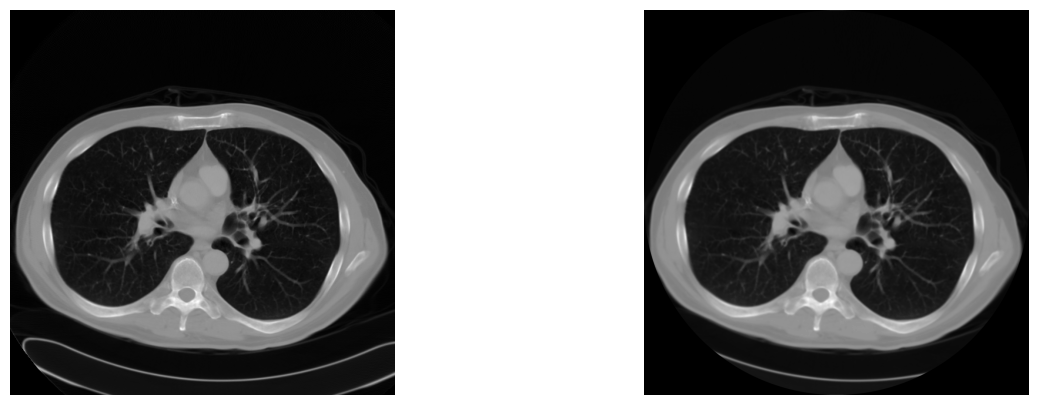

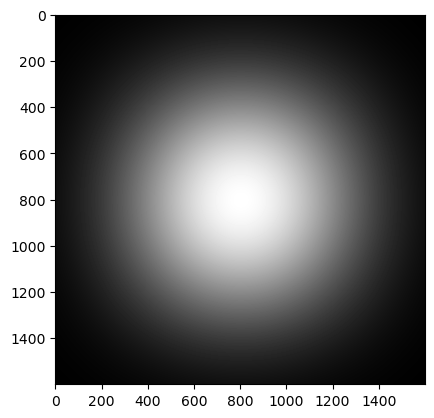

In [3]:
import astra 

N_side = 3000
N_basis = 1600
XX, YY = np.meshgrid(np.linspace(-1.5, 1.5, N_basis), np.linspace(-1.5, 1.5, N_basis))
YY = np.flip(YY, axis=0)
pixelsize = 3/N_basis

spline_basis1 = np.zeros((N_basis, N_basis))
spline_basis1 = np.where(np.abs(YY)<pixelsize, 1, 0)
spline_basis1 = np.where(XX<1/2, spline_basis1, 0)
spline_basis1 = np.where(XX>-1/2, spline_basis1, 0)

spline_basis2 = np.zeros((N_basis, N_basis))
spline_basis2 = np.where(np.abs(XX)<pixelsize, 1, 0)
spline_basis2 = np.where(YY<1/2, spline_basis2, 0)
spline_basis2 = np.where(YY>-1/2, spline_basis2, 0)

spline_basis3 = np.zeros((N_basis, N_basis))
spline_basis3 = np.where(np.abs(XX-YY)<np.sqrt(2)*pixelsize, 1, 0)
spline_basis3 = np.where(XX < 1/2, spline_basis3, 0)
spline_basis3 = np.where((XX) > -1/2, spline_basis3, 0)

spline_basis4 = np.zeros((N_basis, N_basis))
spline_basis4 = np.where(np.abs(XX+YY)<np.sqrt(2)*pixelsize, 1, 0)
spline_basis4 = np.where(XX < 1/2, spline_basis4, 0)
spline_basis4 = np.where((XX) > -1/2, spline_basis4, 0)

spline_basis_0 = fftconvolve(spline_basis1, spline_basis2, mode='same')
spline_basis_1 = fftconvolve(spline_basis_0, spline_basis3, mode='same')
spline_basis_2 = fftconvolve(spline_basis_1, spline_basis4, mode='same')
final_size = N_side
#spline_basis_1 = np.flip(spline_basis_1, axis=0)

#random_phantom = np.random.randn(50, 50)
from skimage import io

image_path = "true.tiff"
# Open the TIFF image
random_phantom = io.imread(image_path)[12:512, :500]
oversampling = 500
factor = final_size//oversampling

spline_basis_3 = fftconvolve(spline_basis_0, spline_basis_0, mode='same')
spline_basis_3 = fftconvolve(spline_basis_3, spline_basis_0, mode='same')
spline_basis_3 = fftconvolve(spline_basis_3, spline_basis_0, mode='same')
spline_basis_3 = fftconvolve(spline_basis_3, spline_basis_0, mode='same') #comment

spline_basis = resize(spline_basis_3, (3*factor, 3*factor), anti_aliasing=False)
full_im_spline = np.zeros((final_size, final_size))
for i in range(oversampling):
    for j in range(oversampling):
        full_im_spline[factor*i + (factor-1)//2, factor*j + (factor-1)//2] = random_phantom[i, j]

phantom = fftconvolve(full_im_spline, spline_basis, mode='same')
#circle mask with zeros outside
XX, YY = np.meshgrid(np.linspace(-1, 1, final_size), np.linspace(-1, 1, final_size))
mask = np.sqrt(XX**2 + YY**2) < 1
phantom = (phantom - np.min(phantom))/(np.max(phantom) - np.min(phantom))
phantom = phantom*mask
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(random_phantom, cmap='gray')
ax[1].imshow(phantom, cmap='gray')
for a in ax:
    a.axis('off')
plt.show()
phantom = cp.array(phantom)/np.max(phantom)
plt.figure()
plt.imshow(spline_basis_3, cmap='gray')
plt.show()

#phantom = create_phantom(N_side, "gaussian")
phantom /= cp.max(phantom)

def run_xp(N_angle, N_offset, oversampling, phantom):
    
    arg_shape = phantom.shape

    pitch_op = (1.,1.) 

    angles = np.linspace(0, 2*np.pi, N_angle, endpoint=False)
    vol_geom = astra.create_vol_geom(phantom.shape[0], phantom.shape[1])
    det_spacing = 1.5*N_side/N_offset
    proj_geom = astra.create_proj_geom('fanflat', det_spacing, N_offset, angles, 6000, 1500)#source_origin, origin_det
    proj_id = astra.create_projector('line_fanflat', proj_geom, vol_geom)
    sinogram_id, y_data_astra = astra.create_sino(np.array(phantom.get()), proj_id)
    y_data = cp.array(y_data_astra).reshape(-1) #+ 1*cp.random.randn(N_angle*N_offset)

    #y_data_astra = op_splines_2.apply(phantom.reshape(-1)).reshape((N_angle, N_offset)).get()
    
    ####### rec astra ########
    
    proj_geom = astra.create_proj_geom('fanflat', 1.5/(N_offset/oversampling) , N_offset, angles, 6000*oversampling/N_side, 1500*oversampling/N_side)#source_origin, origin_det
    vol_geom  = astra.create_vol_geom(oversampling,oversampling)

    proj_id = astra.create_projector('line_fanflat', proj_geom, vol_geom)
    sino_id   = astra.data2d.create('-sino', proj_geom, y_data_astra)
    rec_id    = astra.data2d.create('-vol', vol_geom)

    cfg       = astra.astra_dict('CGLS')
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId']      = sino_id
    cfg['ProjectorId']          = proj_id

    alg_id    = astra.algorithm.create(cfg)
    astra.algorithm.run(alg_id, 30)
    rec_astra              = astra.data2d.get(rec_id)
    ############################


    stop_crit = pxst.MaxIter(30)
    
    pitch_op = (phantom.shape[0]/oversampling, phantom.shape[0]/oversampling)
    arg_shape = (oversampling, oversampling)
    op_pixels, op_splines_1, op_splines_2 = set_operators_fan_beam(N_side, N_angle, N_offset, pitch_op, arg_shape, 6000, 7500) #sod sdd

    recon_pixels = op_pixels.pinv(y_data, damp=0.1, kwargs_fit=dict(stop_crit=stop_crit)).reshape((oversampling, oversampling))
    recon_box_1 = op_splines_1.pinv(y_data, damp=0.1, kwargs_fit=dict(stop_crit=stop_crit)).reshape((oversampling, oversampling))
    recon_box_2 = op_splines_2.pinv(y_data, damp=0.1, kwargs_fit=dict(stop_crit=stop_crit)).reshape((oversampling, oversampling))

    factor = final_size//oversampling


    rec_pix = recon_pixels.get()
    spline_basis = resize(spline_basis_0, (3*factor, 3*factor), mode='reflect', anti_aliasing=False)
    full_im_pix = np.zeros((final_size, final_size))

    for i in range(oversampling):
        for j in range(oversampling):
            full_im_pix[factor*i + (factor-1)//2, factor*j + (factor-1)//2] = rec_pix[i, j]

    full_im_pix = fftconvolve(full_im_pix, spline_basis, mode='same')

    #for astra, use pixels also
    full_im_astra = np.zeros((final_size, final_size))
    for i in range(oversampling):
        for j in range(oversampling):
            full_im_astra[factor*i + (factor-1)//2, factor*j + (factor-1)//2] = rec_astra[i, j]

    full_im_astra = fftconvolve(full_im_astra, spline_basis, mode='same')

    rec_spline = recon_box_1.get()
    spline_basis = resize(spline_basis_1, (3*factor, 3*factor), mode='reflect', anti_aliasing=False)
    full_im_spline = np.zeros((final_size, final_size))
    for i in range(oversampling):
        for j in range(oversampling):
            full_im_spline[factor*i + (factor-1)//2, factor*j + (factor-1)//2] = rec_spline[i, j]

    full_im_spline1 = fftconvolve(full_im_spline, spline_basis, mode='same')

    rec_spline = recon_box_2.get()
    spline_basis = resize(spline_basis_2, (3*factor, 3*factor), mode='reflect', anti_aliasing=False)
    full_im_spline = np.zeros((final_size, final_size))
    for i in range(oversampling):
        for j in range(oversampling):
            full_im_spline[factor*i + (factor-1)//2, factor*j + (factor-1)//2] = rec_spline[i, j]

    full_im_spline2 = fftconvolve(full_im_spline, spline_basis, mode='same')

    fig, ax = plt.subplots(1, 4, figsize=(15, 5))
    ax[0].imshow(full_im_pix, cmap='gray')
    ax[1].imshow(full_im_spline1, cmap='gray')
    ax[2].imshow(full_im_spline2, cmap='gray')
    ax[3].imshow(full_im_astra, cmap='gray')
    
    for a in ax:
        a.axis('off')
    #plt.savefig('upsampled.eps', format='eps')

    loss1 = psnr(phantom.get()/np.max(phantom.get()), full_im_pix/np.max(full_im_pix))
    loss2 = psnr(phantom.get()/np.max(phantom.get()), full_im_spline1/np.max(full_im_spline1))
    loss3 = psnr(phantom.get()/np.max(phantom.get()), full_im_spline2/np.max(full_im_spline2))
    loss4 = psnr(phantom.get()/np.max(phantom.get()), full_im_astra/np.max(full_im_astra))

    ssim1 = ssim(phantom.get()/np.max(phantom.get()), full_im_pix/np.max(full_im_pix), data_range=2)
    ssim2 = ssim(phantom.get()/np.max(phantom.get()), full_im_spline1/np.max(full_im_spline1), data_range=2)
    ssim3 = ssim(phantom.get()/np.max(phantom.get()), full_im_spline2/np.max(full_im_spline2), data_range=2)
    ssim4 = ssim(phantom.get()/np.max(phantom.get()), full_im_astra/np.max(full_im_astra), data_range=2)
    
    plt.show()
    
    return loss1, loss2, loss3, loss4, full_im_pix, full_im_spline1, full_im_spline2, full_im_astra, ssim1, ssim2, ssim3, ssim4


INFO:/tmp/pyxu_12yt_tx2:[2025-03-17 12:38:29.720544] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_12yt_tx2:[2025-03-17 12:38:29.741942] Iteration 1
	iteration: 1
	N_iter: 2.0


Oversampling :  20


INFO:/tmp/pyxu_12yt_tx2:[2025-03-17 12:38:29.755252] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_12yt_tx2:[2025-03-17 12:38:29.767882] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_12yt_tx2:[2025-03-17 12:38:29.780455] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_12yt_tx2:[2025-03-17 12:38:29.792848] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_12yt_tx2:[2025-03-17 12:38:29.805382] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_12yt_tx2:[2025-03-17 12:38:29.817608] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_12yt_tx2:[2025-03-17 12:38:29.830000] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_12yt_tx2:[2025-03-17 12:38:29.842154] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_12yt_tx2:[2025-03-17 12:38:29.854339] Iteration 10
	iteration: 10
	N_iter: 11.0
INFO:/tmp/pyxu_12yt_tx2:[2025-03-17 12:38:29.866525] Iteration 11
	iteration: 11
	N_iter: 12.0
INFO:/tmp/pyxu_12yt_tx2:[2025-03-17 12:38:29.878786] Iteration 12
	iterat

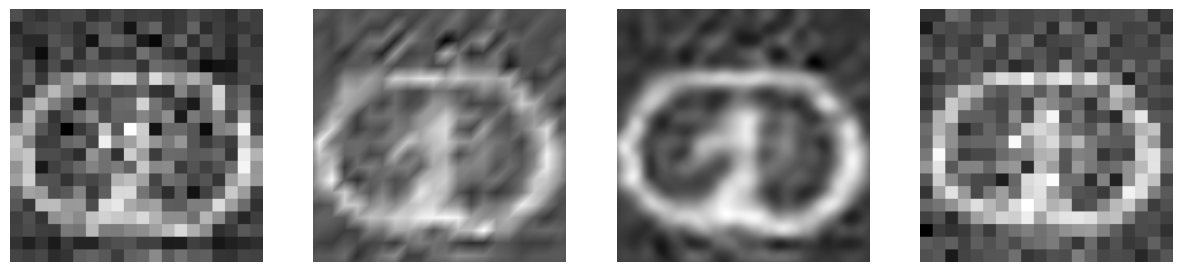

Losses :  13.855224011794318 16.798423550186243 16.0927647758349 15.00887127160608
SSIM :  0.4162643266378717 0.5355860920715982 0.5741294391983246 0.42048988808088367
Oversampling :  40


INFO:/tmp/pyxu_0c3wp5kq:[2025-03-17 12:38:43.040438] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_0c3wp5kq:[2025-03-17 12:38:43.061475] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_0c3wp5kq:[2025-03-17 12:38:43.073955] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_0c3wp5kq:[2025-03-17 12:38:43.086149] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_0c3wp5kq:[2025-03-17 12:38:43.098368] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_0c3wp5kq:[2025-03-17 12:38:43.110697] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_0c3wp5kq:[2025-03-17 12:38:43.122900] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_0c3wp5kq:[2025-03-17 12:38:43.135409] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_0c3wp5kq:[2025-03-17 12:38:43.147596] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_0c3wp5kq:[2025-03-17 12:38:43.159868] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_0c3wp5kq:[2025-03-17 12:38:43.172162] Iteration 10
	iteration: 1

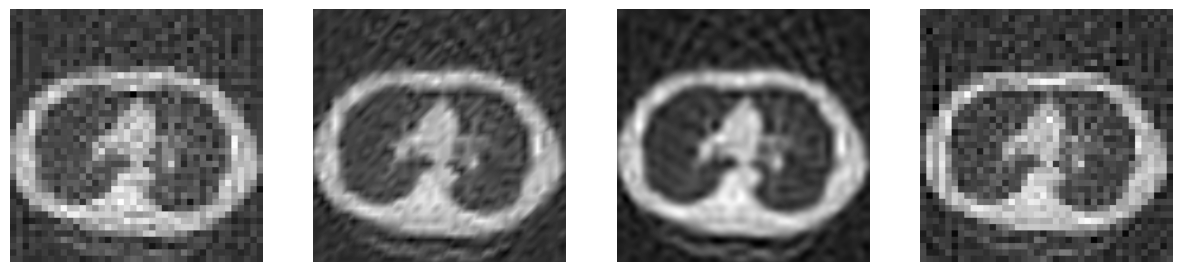

Losses :  17.21218217414006 19.66203914172962 18.296971401450428 18.045435336774084
SSIM :  0.5220820996727932 0.6526042057427729 0.6827633428563035 0.5191773660970103
Oversampling :  50


INFO:/tmp/pyxu_w44v0c0l:[2025-03-17 12:38:56.199841] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_w44v0c0l:[2025-03-17 12:38:56.221518] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_w44v0c0l:[2025-03-17 12:38:56.234084] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_w44v0c0l:[2025-03-17 12:38:56.246320] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_w44v0c0l:[2025-03-17 12:38:56.258509] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_w44v0c0l:[2025-03-17 12:38:56.271029] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_w44v0c0l:[2025-03-17 12:38:56.283371] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_w44v0c0l:[2025-03-17 12:38:56.295721] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_w44v0c0l:[2025-03-17 12:38:56.308039] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_w44v0c0l:[2025-03-17 12:38:56.320347] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_w44v0c0l:[2025-03-17 12:38:56.332621] Iteration 10
	iteration: 1

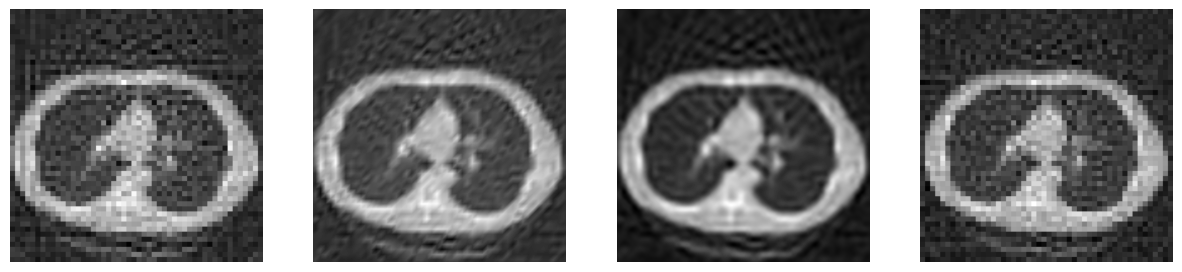

Losses :  18.291559704568733 20.682866256804605 20.463232240396536 19.967179881269416
SSIM :  0.5412005036904523 0.6964139569788187 0.7408317139694656 0.5758034508774432
Oversampling :  75


INFO:/tmp/pyxu_it86el75:[2025-03-17 12:39:10.170295] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_it86el75:[2025-03-17 12:39:10.191962] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_it86el75:[2025-03-17 12:39:10.204571] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_it86el75:[2025-03-17 12:39:10.216934] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_it86el75:[2025-03-17 12:39:10.229183] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_it86el75:[2025-03-17 12:39:10.241364] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_it86el75:[2025-03-17 12:39:10.253589] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_it86el75:[2025-03-17 12:39:10.265982] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_it86el75:[2025-03-17 12:39:10.278348] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_it86el75:[2025-03-17 12:39:10.290670] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_it86el75:[2025-03-17 12:39:10.303003] Iteration 10
	iteration: 1

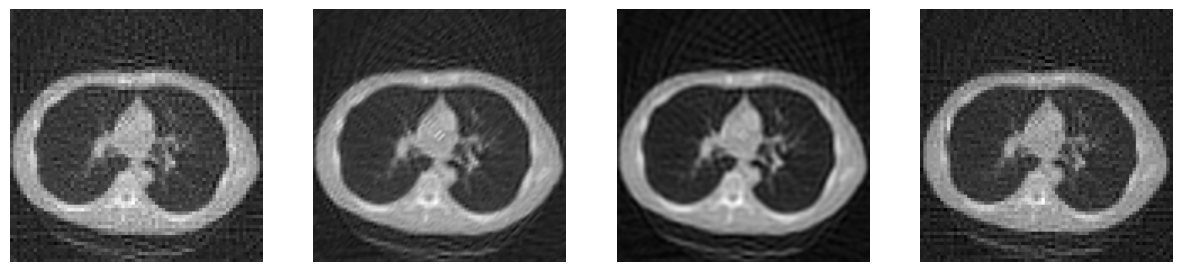

Losses :  21.167106297599524 23.853288251134558 24.168921011838563 23.218112299815857
SSIM :  0.632873354916033 0.7785093572637752 0.8179726306746674 0.6674079395652259
Oversampling :  100


INFO:/tmp/pyxu_v5h1lr1_:[2025-03-17 12:39:25.211393] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_v5h1lr1_:[2025-03-17 12:39:25.233238] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_v5h1lr1_:[2025-03-17 12:39:25.245814] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_v5h1lr1_:[2025-03-17 12:39:25.258039] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_v5h1lr1_:[2025-03-17 12:39:25.270182] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_v5h1lr1_:[2025-03-17 12:39:25.282495] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_v5h1lr1_:[2025-03-17 12:39:25.294688] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_v5h1lr1_:[2025-03-17 12:39:25.306839] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_v5h1lr1_:[2025-03-17 12:39:25.319089] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_v5h1lr1_:[2025-03-17 12:39:25.331444] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_v5h1lr1_:[2025-03-17 12:39:25.343775] Iteration 10
	iteration: 1

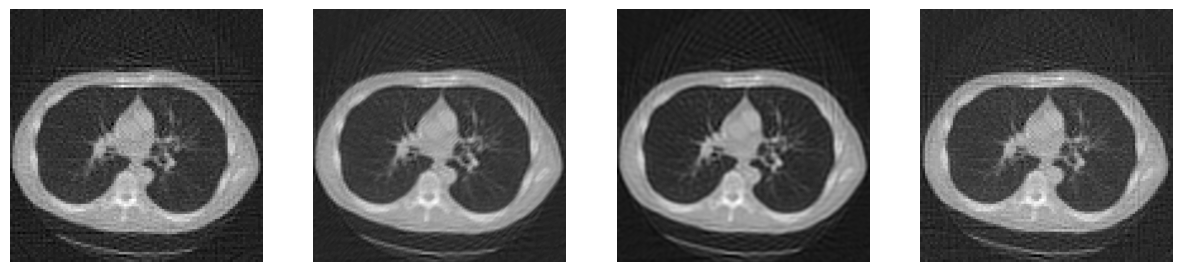

Losses :  23.206662582703487 25.743394858777094 26.054473871681285 24.8053920215605
SSIM :  0.7093930000813868 0.8397026898717059 0.8678241159019997 0.7324466541875994
Oversampling :  120


INFO:/tmp/pyxu_lj6x28tj:[2025-03-17 12:39:41.076137] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_lj6x28tj:[2025-03-17 12:39:41.097975] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_lj6x28tj:[2025-03-17 12:39:41.110450] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_lj6x28tj:[2025-03-17 12:39:41.122720] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_lj6x28tj:[2025-03-17 12:39:41.134924] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_lj6x28tj:[2025-03-17 12:39:41.147399] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_lj6x28tj:[2025-03-17 12:39:41.159763] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_lj6x28tj:[2025-03-17 12:39:41.172133] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_lj6x28tj:[2025-03-17 12:39:41.184378] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_lj6x28tj:[2025-03-17 12:39:41.196707] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_lj6x28tj:[2025-03-17 12:39:41.209709] Iteration 10
	iteration: 1

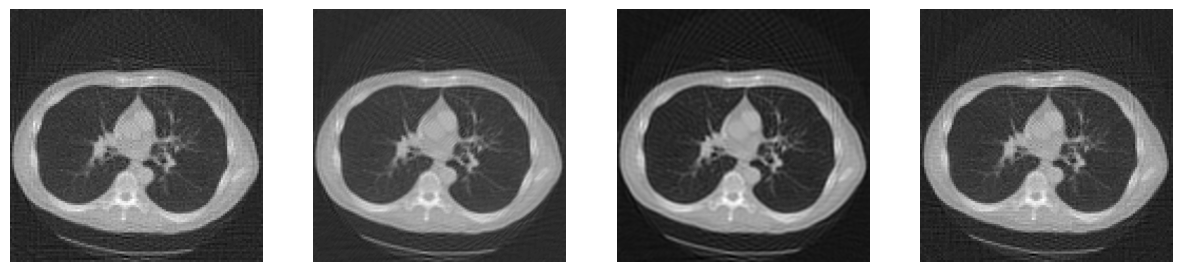

Losses :  24.221972175046606 26.94180556470861 26.69066942577352 26.25359767860713
SSIM :  0.7515305996211499 0.8720117531722786 0.8942307495026286 0.7782042061594971
Oversampling :  150


INFO:/tmp/pyxu_vxgiic7q:[2025-03-17 12:39:58.931448] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_vxgiic7q:[2025-03-17 12:39:58.953516] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_vxgiic7q:[2025-03-17 12:39:58.965977] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_vxgiic7q:[2025-03-17 12:39:58.978145] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_vxgiic7q:[2025-03-17 12:39:58.990401] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_vxgiic7q:[2025-03-17 12:39:59.002586] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_vxgiic7q:[2025-03-17 12:39:59.014713] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_vxgiic7q:[2025-03-17 12:39:59.026895] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_vxgiic7q:[2025-03-17 12:39:59.039089] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_vxgiic7q:[2025-03-17 12:39:59.051305] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_vxgiic7q:[2025-03-17 12:39:59.063418] Iteration 10
	iteration: 1

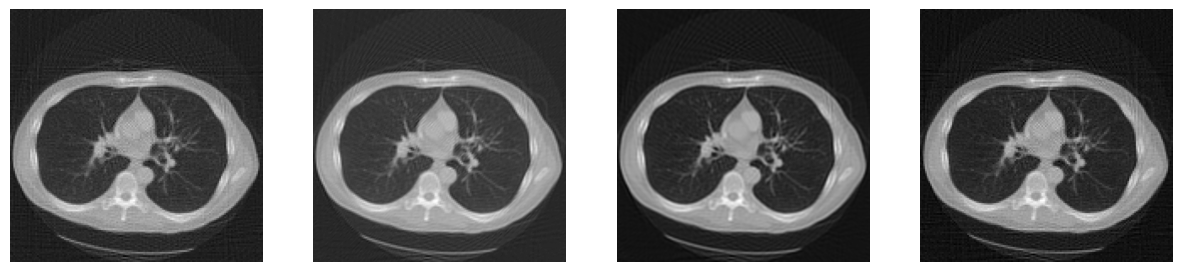

Losses :  26.004954287879286 27.968397985190855 28.617681809789588 27.53779591429584
SSIM :  0.8058383983673629 0.9036691098168878 0.9288021870945428 0.8165690992128539
Oversampling :  200


INFO:/tmp/pyxu_41o54tga:[2025-03-17 12:40:21.650122] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_41o54tga:[2025-03-17 12:40:21.672321] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_41o54tga:[2025-03-17 12:40:21.685035] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_41o54tga:[2025-03-17 12:40:21.697619] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_41o54tga:[2025-03-17 12:40:21.710116] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_41o54tga:[2025-03-17 12:40:21.722464] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_41o54tga:[2025-03-17 12:40:21.734966] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_41o54tga:[2025-03-17 12:40:21.747738] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_41o54tga:[2025-03-17 12:40:21.760100] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_41o54tga:[2025-03-17 12:40:21.772526] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_41o54tga:[2025-03-17 12:40:21.784952] Iteration 10
	iteration: 1

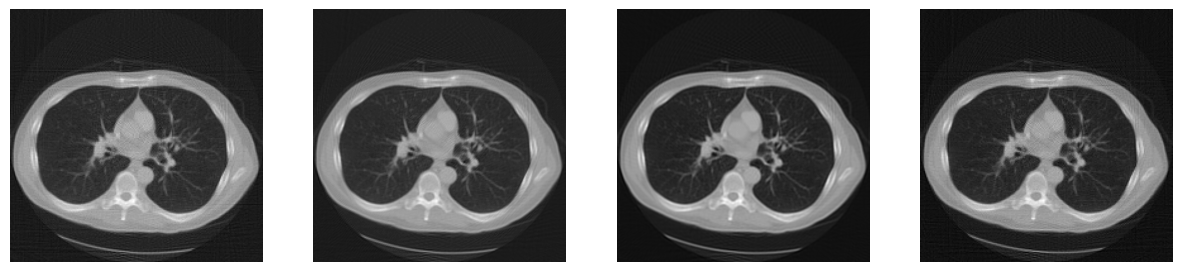

Losses :  27.79438894735982 30.81952091762234 30.944130704568764 30.149310261142496
SSIM :  0.8553323836571487 0.938526389142883 0.9565893482781359 0.8675332151215989
Oversampling :  250


INFO:/tmp/pyxu_v5h4lu9x:[2025-03-17 12:40:51.827448] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_v5h4lu9x:[2025-03-17 12:40:51.850248] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_v5h4lu9x:[2025-03-17 12:40:51.863035] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_v5h4lu9x:[2025-03-17 12:40:51.875670] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_v5h4lu9x:[2025-03-17 12:40:51.888167] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_v5h4lu9x:[2025-03-17 12:40:51.900758] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_v5h4lu9x:[2025-03-17 12:40:51.913106] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_v5h4lu9x:[2025-03-17 12:40:51.925643] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_v5h4lu9x:[2025-03-17 12:40:51.938269] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_v5h4lu9x:[2025-03-17 12:40:51.951145] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_v5h4lu9x:[2025-03-17 12:40:51.963563] Iteration 10
	iteration: 1

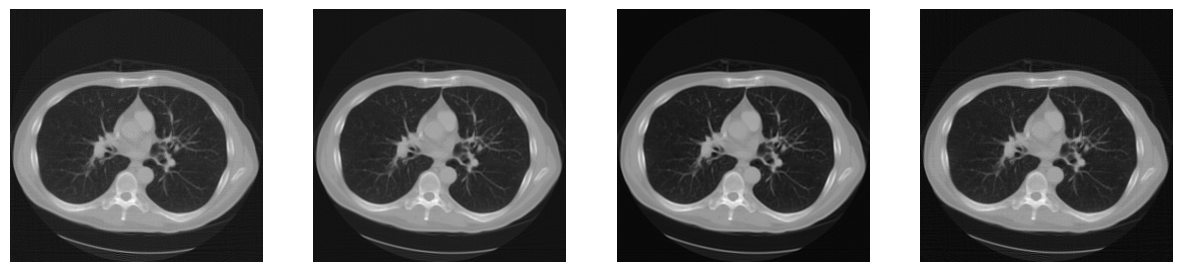

Losses :  29.779569870247506 32.498716174464505 32.85409647653694 32.08361866414294
SSIM :  0.8926102810008382 0.958438101042574 0.9717750110160659 0.8989499552920371
Oversampling :  300


INFO:/tmp/pyxu_98j8g5z2:[2025-03-17 12:41:32.274558] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_98j8g5z2:[2025-03-17 12:41:32.298610] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_98j8g5z2:[2025-03-17 12:41:32.311927] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_98j8g5z2:[2025-03-17 12:41:32.325220] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_98j8g5z2:[2025-03-17 12:41:32.338290] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_98j8g5z2:[2025-03-17 12:41:32.351280] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_98j8g5z2:[2025-03-17 12:41:32.364792] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_98j8g5z2:[2025-03-17 12:41:32.377839] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_98j8g5z2:[2025-03-17 12:41:32.390929] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_98j8g5z2:[2025-03-17 12:41:32.403981] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_98j8g5z2:[2025-03-17 12:41:32.416944] Iteration 10
	iteration: 1

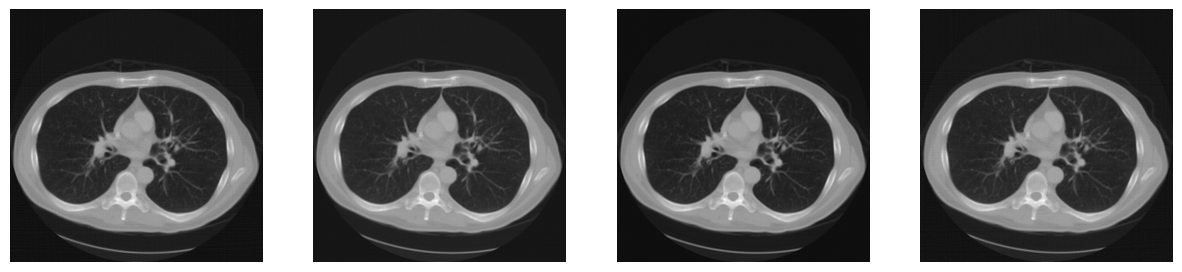

Losses :  31.315603074262604 34.049421728415126 34.31883977754509 33.46399123157428
SSIM :  0.9115694576071264 0.9682716899633953 0.977890476662654 0.9175038431337601
Oversampling :  375


INFO:/tmp/pyxu_nw39861w:[2025-03-17 12:42:34.674937] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_nw39861w:[2025-03-17 12:42:34.700620] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_nw39861w:[2025-03-17 12:42:34.715472] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_nw39861w:[2025-03-17 12:42:34.730288] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_nw39861w:[2025-03-17 12:42:34.745181] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_nw39861w:[2025-03-17 12:42:34.759938] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_nw39861w:[2025-03-17 12:42:34.774838] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_nw39861w:[2025-03-17 12:42:34.789679] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_nw39861w:[2025-03-17 12:42:34.804558] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_nw39861w:[2025-03-17 12:42:34.819276] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_nw39861w:[2025-03-17 12:42:34.833974] Iteration 10
	iteration: 1

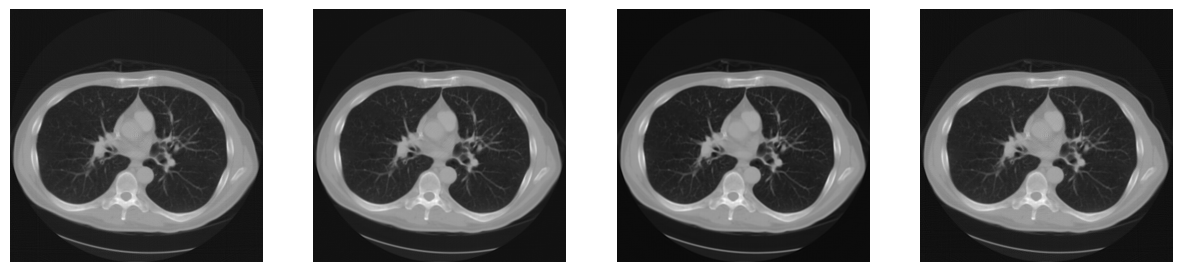

Losses :  32.92435711682868 35.70715927276911 35.95562588413034 34.8965193506416
SSIM :  0.9300836358000034 0.9752987245750678 0.9819815813902728 0.9328783038330642
Oversampling :  500


INFO:/tmp/pyxu_knqqd1yz:[2025-03-17 12:44:35.674557] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_knqqd1yz:[2025-03-17 12:44:35.701427] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_knqqd1yz:[2025-03-17 12:44:35.720734] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_knqqd1yz:[2025-03-17 12:44:35.739530] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_knqqd1yz:[2025-03-17 12:44:35.759311] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_knqqd1yz:[2025-03-17 12:44:35.779489] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_knqqd1yz:[2025-03-17 12:44:35.798872] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_knqqd1yz:[2025-03-17 12:44:35.817989] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_knqqd1yz:[2025-03-17 12:44:35.837555] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_knqqd1yz:[2025-03-17 12:44:35.855502] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_knqqd1yz:[2025-03-17 12:44:35.873612] Iteration 10
	iteration: 1

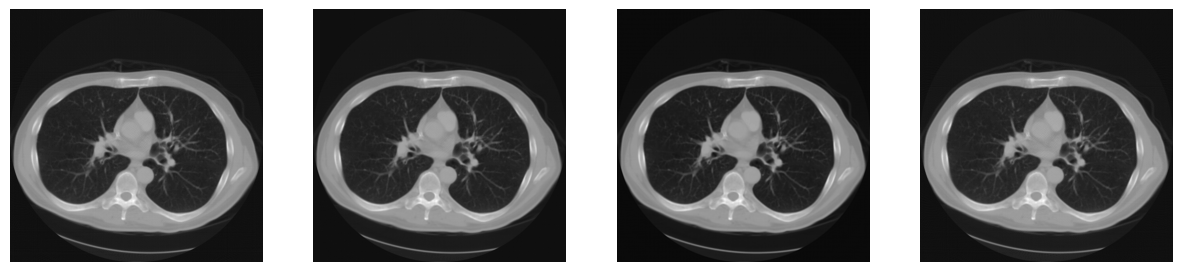

Losses :  34.900433446604815 37.7421986068445 37.94726942822037 36.83678252940737
SSIM :  0.9511698690172137 0.982340564729494 0.9863713469793277 0.9528870891032067
Oversampling :  1000


INFO:/tmp/pyxu_9mf20k5i:[2025-03-17 12:57:51.280224] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_9mf20k5i:[2025-03-17 12:57:51.447303] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_9mf20k5i:[2025-03-17 12:57:51.585461] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_9mf20k5i:[2025-03-17 12:57:51.723713] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_9mf20k5i:[2025-03-17 12:57:51.861961] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_9mf20k5i:[2025-03-17 12:57:51.999048] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_9mf20k5i:[2025-03-17 12:57:52.136531] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_9mf20k5i:[2025-03-17 12:57:52.275419] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_9mf20k5i:[2025-03-17 12:57:52.411873] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_9mf20k5i:[2025-03-17 12:57:52.550215] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_9mf20k5i:[2025-03-17 12:57:52.687209] Iteration 10
	iteration: 1

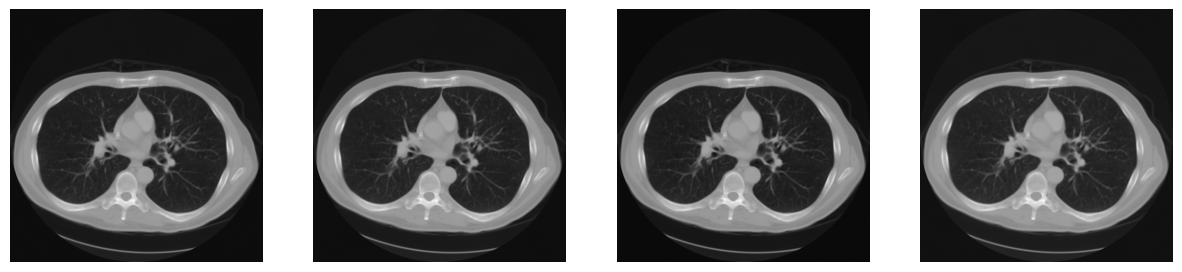

Losses :  38.735980041295285 40.864741421443 41.34958569184255 39.46139278819877
SSIM :  0.9745484236825279 0.98642361524617 0.9887888119211766 0.9735164095701284


In [5]:
oversamplings =[20, 40, 50, 75, 100, 120, 150, 200, 250, 300, 375, 500, 1000]

losses1 = []
losses2 = []
losses3 = []
losses4 = []

ssims1 = []
ssims2 = []
ssims3 = []
ssims4 = []

images_pix = []
images_spline1 = []
images_spline2 = []
images_astra = []

for oversampling in oversamplings:
    print('Oversampling : ', oversampling)
    loss1, loss2, loss3, loss4, full_im_pix, full_im_spline1, full_im_spline2, full_im_astra, ssim1, ssim2, ssim3, ssim4 = run_xp(int(2*oversampling), int(1*oversampling), oversampling, phantom)
    losses1.append(loss1)
    losses2.append(loss2)
    losses3.append(loss3)
    losses4.append(loss4)
    ssims1.append(ssim1)
    ssims2.append(ssim2)
    ssims3.append(ssim3)
    ssims4.append(ssim4)


    images_pix.append(full_im_pix)
    images_spline1.append(full_im_spline1)
    images_spline2.append(full_im_spline2)
    images_astra.append(full_im_astra)
    
    print('Losses : ', loss1, loss2, loss3, loss4)
    print('SSIM : ', ssim1, ssim2, ssim3, ssim4)

In [10]:
#save everything
np.save('oversamplings.npy', oversamplings)
np.save('losses1_cone.npy', losses1)
np.save('losses2_cone.npy', losses2)
np.save('losses3_cone.npy', losses3)
np.save('losses4_cone.npy', losses4)
np.save('ssims1_cone.npy', ssims1)
np.save('ssims2_cone.npy', ssims2)
np.save('ssims3_cone.npy', ssims3)
np.save('ssims4_cone.npy', ssims4)
'''
np.save('images_pix.npy', images_pix)
np.save('images_spline1.npy', images_spline1)
np.save('images_spline2.npy', images_spline2)
np.save('images_astra.npy', images_astra)'''

"\nnp.save('images_pix.npy', images_pix)\nnp.save('images_spline1.npy', images_spline1)\nnp.save('images_spline2.npy', images_spline2)\nnp.save('images_astra.npy', images_astra)"

In [6]:
#load everything
oversamplings = np.load('oversamplings.npy')
losses1 = np.load('losses1.npy')
losses2 = np.load('losses2.npy')
losses3 = np.load('losses3.npy')
losses4 = np.load('losses4.npy')
ssims1 = np.load('ssims1.npy')
ssims2 = np.load('ssims2.npy')
ssims3 = np.load('ssims3.npy')
ssims4 = np.load('ssims4.npy')
images_pix = np.load('images_pix.npy')
images_spline1 = np.load('images_spline1.npy')
images_spline2 = np.load('images_spline2.npy')
images_astra = np.load('images_astra.npy')

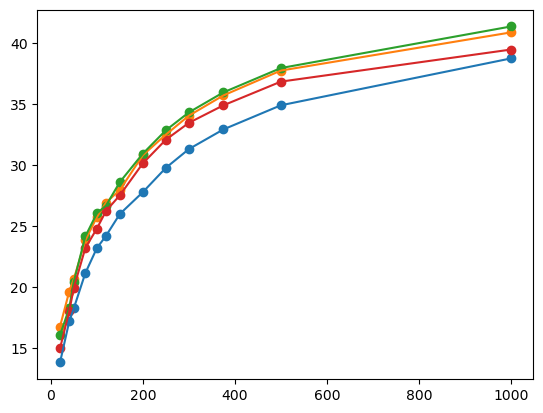

In [7]:

plt.figure('Losses')
plt.plot(oversamplings, losses1, label='Pixels psnr')
plt.plot(oversamplings, losses2, label='Box-splines 1 psnr')
plt.plot(oversamplings, losses3, label='Box-splines 2 psnr')
plt.plot(oversamplings, losses4, label='Astra psnr')

plt.scatter(oversamplings, losses1)
plt.scatter(oversamplings, losses2)
plt.scatter(oversamplings, losses3)
plt.scatter(oversamplings, losses4)
# max of y is 40
#plt.legend()
plt.show()

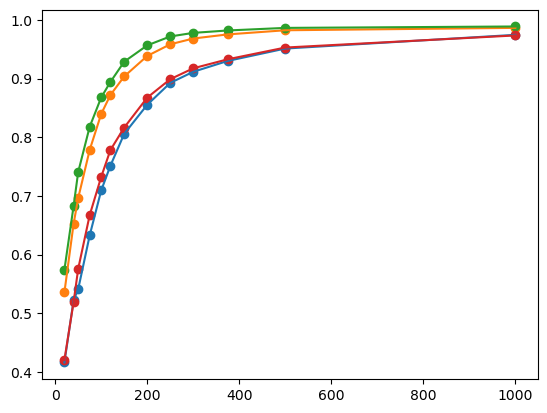

In [8]:
plt.figure('SSIM')
plt.plot(oversamplings, ssims1, label='Pixels ssim')
plt.plot(oversamplings, ssims2, label='Box-splines 1 ssim')
plt.plot(oversamplings, ssims3, label='Box-splines 2 ssim')
plt.plot(oversamplings, ssims4, label='Astra ssim')

plt.scatter(oversamplings, ssims1)
plt.scatter(oversamplings, ssims2)
plt.scatter(oversamplings, ssims3)
plt.scatter(oversamplings, ssims4)

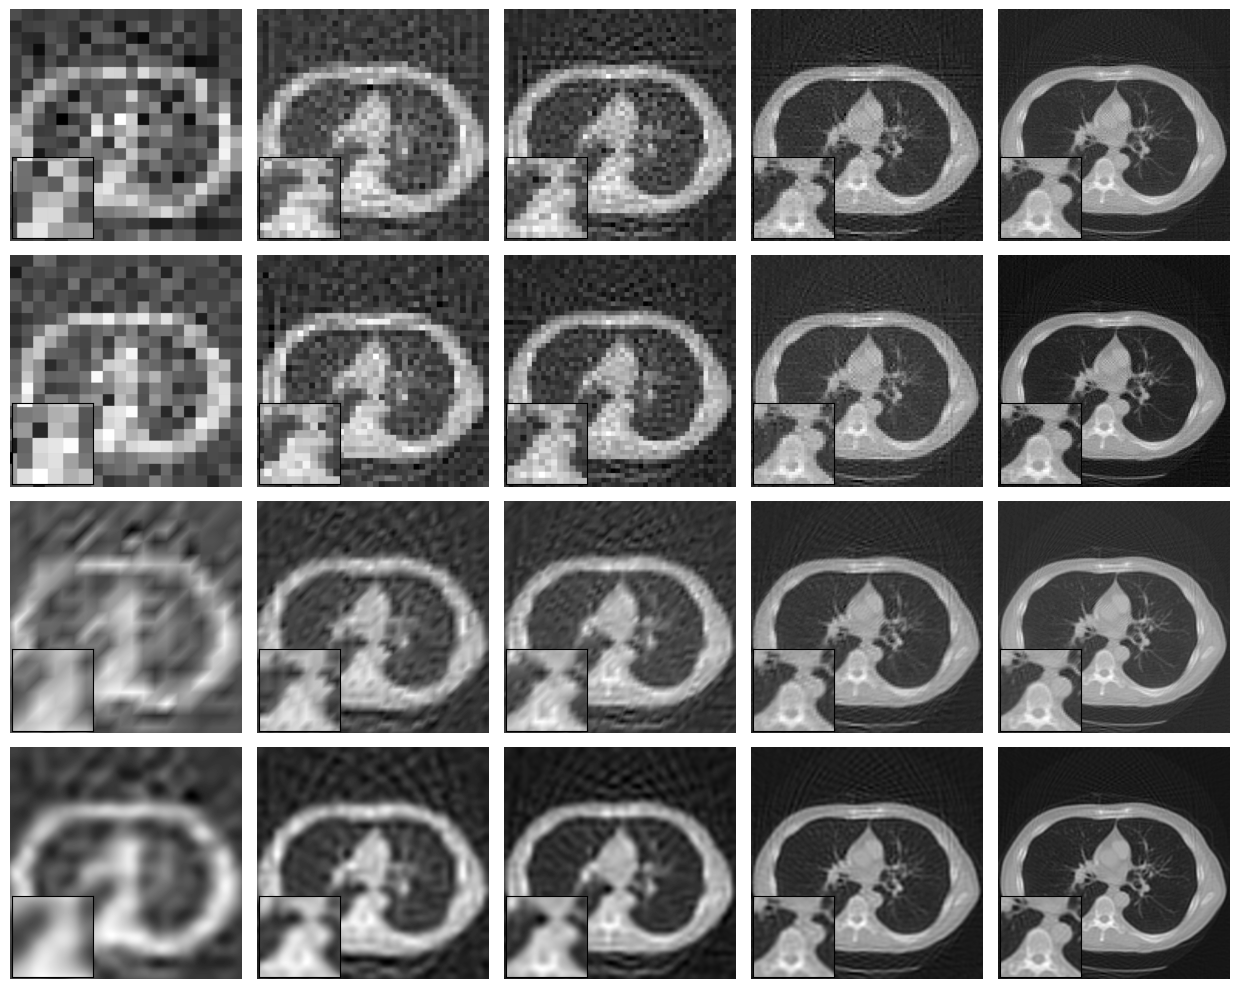

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Create figure and subplots
fig, ax = plt.subplots(4, 5, figsize=(10*5/4, 10))
k = 0

# Define the zoom-in region (adjust these values based on your images)
x1, x2, y1, y2 = 1000, 1800, 600, 1400  # Example: Region to zoom into

for i in range(len(oversamplings)):
    if i in [0, 1, 2, 4, 6]:#, 12]:  # Select specific oversampling values
        images = [images_pix[i], images_astra[i], images_spline1[i], images_spline2[i]]
        
        for row in range(4):
            # Display main image
            ax[row, k].imshow(images[row], cmap='gray')
            ax[row, k].axis('off')

            # Add inset for zoomed-in view
            axins = ax[row, k].inset_axes([0.01, 0.01, 0.35, 0.35])  # (x, y, width, height)
            #remove ticks
            axins.set_xticks([])
            axins.set_yticks([])

            # Display zoomed-in region
            axins.imshow(images[row], cmap='gray', extent=[0, images[row].shape[1], 0, images[row].shape[0]])

            # Define zoom region
            axins.set_xlim(x1, x2)
            axins.set_ylim(y1, y2)
            axins

        k += 1

        #tight layout
plt.tight_layout()
plt.savefig('table_img2_cone.eps', format='eps')
plt.show()
